In [1]:
import lsst.daf.persistence as dafPersist
import matplotlib.pyplot as plt
import numpy as np

import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import Utils.DiaSourceTools as DSTools
from astropy.time import Time

import lsst.afw.display.ds9 as ds9

import re

import glob
from astropy.io import ascii

/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [7]:
DATADIR="/datadec/cppm/jpreyes/CFHT_Jointcal_2/light_curves/"
sns = [ 25739,  39480,  28461,  36919,   9126,  36994,   8654,   8138,  37538,  39142,  36046,  19261,  25062,  37671,  27179,  37686,  28780,  39306, 39342,  37787]

In [8]:
sn_tables = []
for sn in sns:
    sn_tables.append(ascii.read(DATADIR+str(sn)+".dat"))

This is the colour map. You can modify these values to change the light curve point colors.

In [9]:
stack_colors = {"sdssg":"green", "sdssi":"blue", "sdssr":"red", "sdssz":"magenta"}

snls_colors = {"sdssg":"darkgreen", "sdssi":"darkblue", "sdssr":"darkred", "sdssz":"purple"}

Loading of SNLS Data

In [10]:
def show_multi_filter_light_curve(t, colors, n_factor = None):

    t_by_filter = t.group_by("bandpass")

    indices = t_by_filter.groups.indices
    #print indices

    for i in range(0, len(indices)-1):

        data = t_by_filter[indices[i]:indices[i+1]]
        
        if n_factor is not None:
            value = n_factor[data[0]["bandpass"]]
            f = value if np.isnan(value) == False else 1
            plt.errorbar(data["mjd"], data["flux"]*f,yerr=data["flux_error"]*f, fmt='.', markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])            
        else:
            plt.errorbar(data["mjd"], data["flux"],yerr=data["flux_error"], fmt='.', markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])
    plt.legend()
    #plt.show()

06D3bz 214.291841667 53.024825


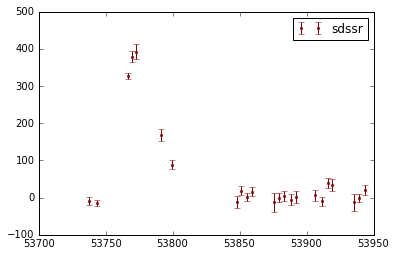

06D3cb 215.181558333 52.1910638889


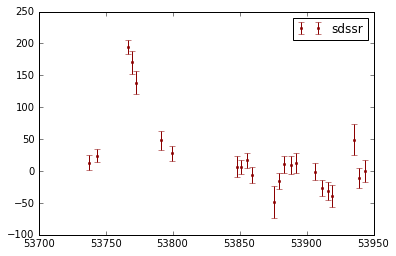

06D3cc 214.381666667 52.9124722222


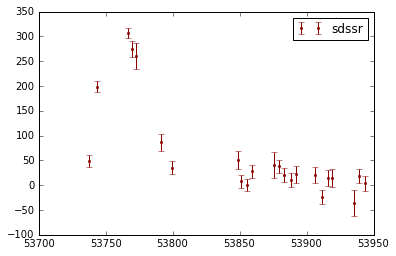

06D3cn 214.8577 52.6409833333


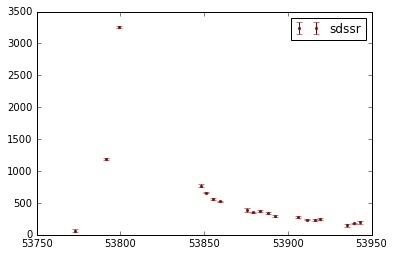

06D3df 215.571704167 52.9576805556


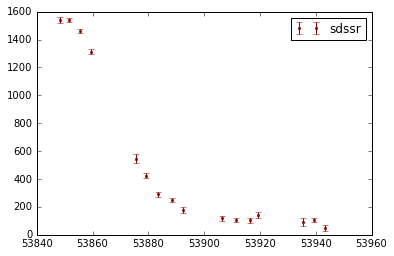

06D3dl 215.552404167 52.6408472222


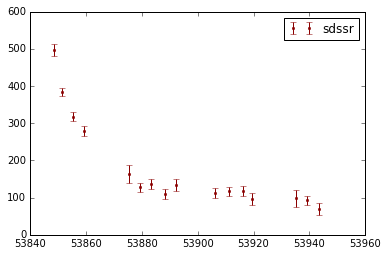

06D3do 214.247466667 52.8825444444


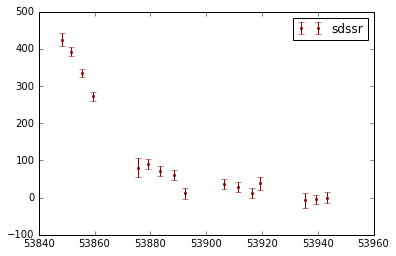

06D3dt 214.340266667 52.4528166667


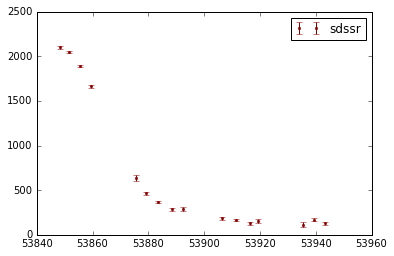

06D3ed 214.699175 52.7565583333


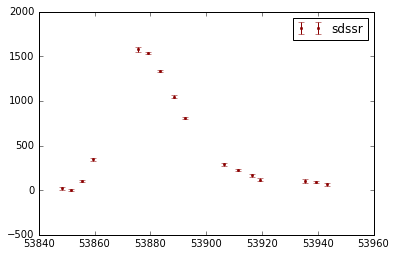

06D3el 214.254529167 52.2324


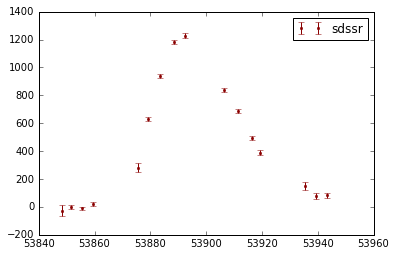

06D3em 214.847579167 53.0230138889


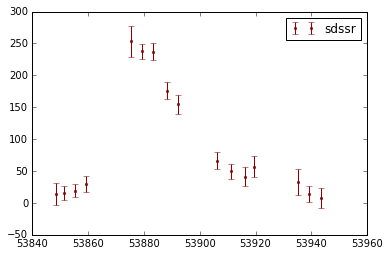

06D3en 215.305566667 52.4560777778


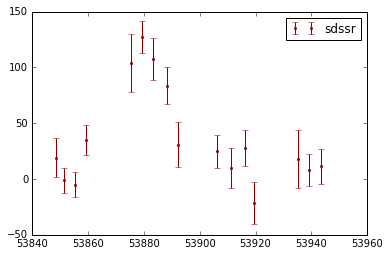

06D3et 215.519875 52.3383666667


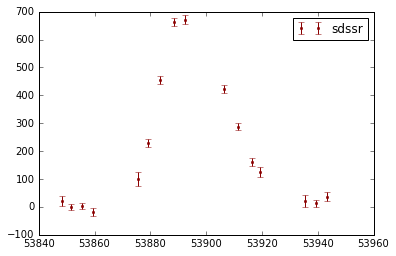

06D3fp 215.077520833 52.8971638889


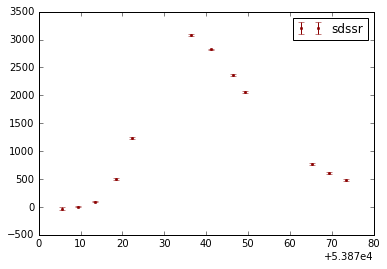

06D3gh 214.6309125 52.4429083333


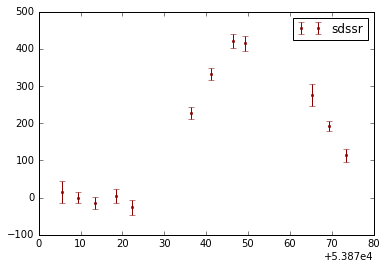

06D3gn 214.435958333 52.3611805556


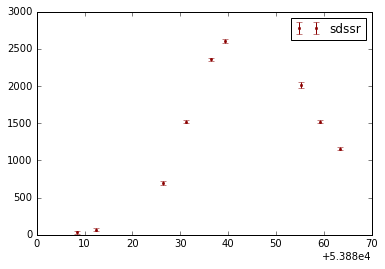

06D3gx 214.263475 52.9362527778


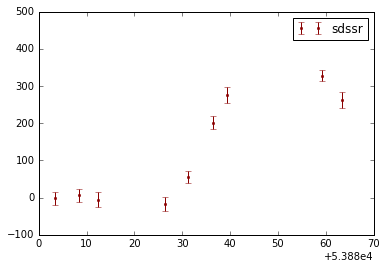

total of sn:17


In [11]:
%matplotlib inline
import re
import astropy.coordinates as coord
import astropy.units as u


f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table9.dat.txt','r')
data_elems = f.read()
elems = re.findall('^(06D3.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)

f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table10.dat.txt','r')
data = f.read()

snls_array = []
for sn in elems:
    c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))
    
    m = re.findall('^'+str(sn[0])+'\\|(r)\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

    snls_lc = DSTools.build_light_curve_from_snls_file(m, c)
    
    #print m
    print sn[0], c.ra.deg, c.dec.deg
    
    #plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue')
    show_multi_filter_light_curve(snls_lc, snls_colors)
    plt.show()
    snls_array.append(snls_lc)
    
print("total of sn:" + str(len(snls_array)))

In [12]:
def match_with_lc(snls_array, stack_lc):
    matches = []
    for lc in snls_array:
        #print "light curve"
        val = {"ra":lc[0]["ra"], "dec":lc[0]["dec"]}
        #print np.rad2deg(lc[0]["ra"]), np.rad2deg(lc[0]["dec"])
        for i, slc in enumerate(stack_lc):

            comp = {"ra":np.mean(slc["ra"]), "dec":np.mean(slc["dec"])}
            if DSTools.source_distance(val, comp)<1:
                print i
                matches.append((lc,slc))


    print len(matches)
    return matches

In [15]:
matches_45= match_with_lc(snls_array, sn_tables)
print "total", len(matches_45), " of ", len(snls_array)

15
10
12
6
7
9
17
3
5
14
16
19
0
4
11
2
1
8
13
18
20
total 20  of  17


In [16]:
from scipy.stats import sigmaclip

def normalize_light_curve(lc1, lc2, filter):
   
    l1 = lc1[lc1['bandpass']==filter]
    l2 = lc2[lc2['bandpass']==filter]
    norm = []
    for row1 in l1:
        for row2 in l2:
            if int(row1["mjd"]) == int(row2["mjd"]):
                norm.append(row1["flux"]/row2["flux"])
                
    c_array = sigmaclip(norm, low=1.5, high=1.5)
    return c_array.clipped.mean()

214.291900931 53.0247739515
{'sdssr': 22.293376732094572}


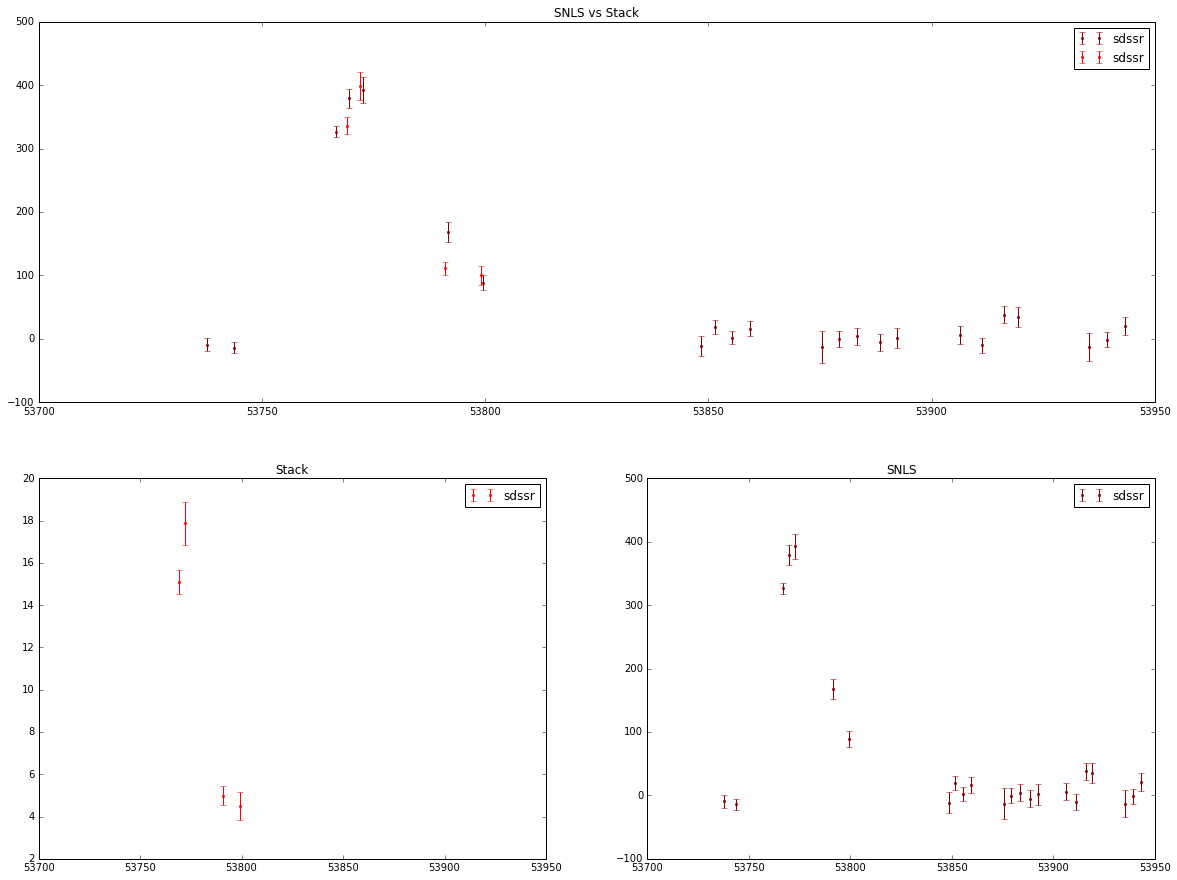

214.3817236 52.9124189608
{'sdssr': 8.8185170189876843}


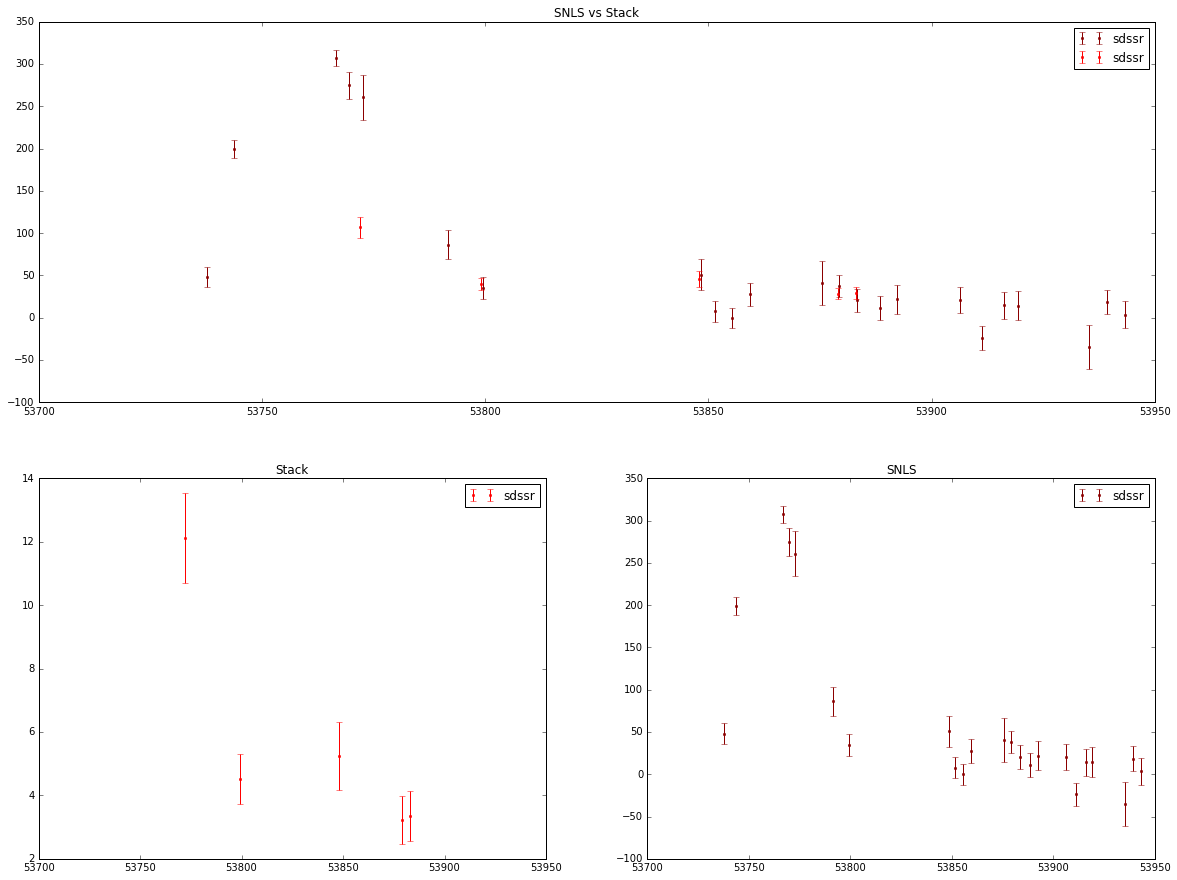

214.857560259 52.6409691946
{'sdssr': 22.901844749267863}


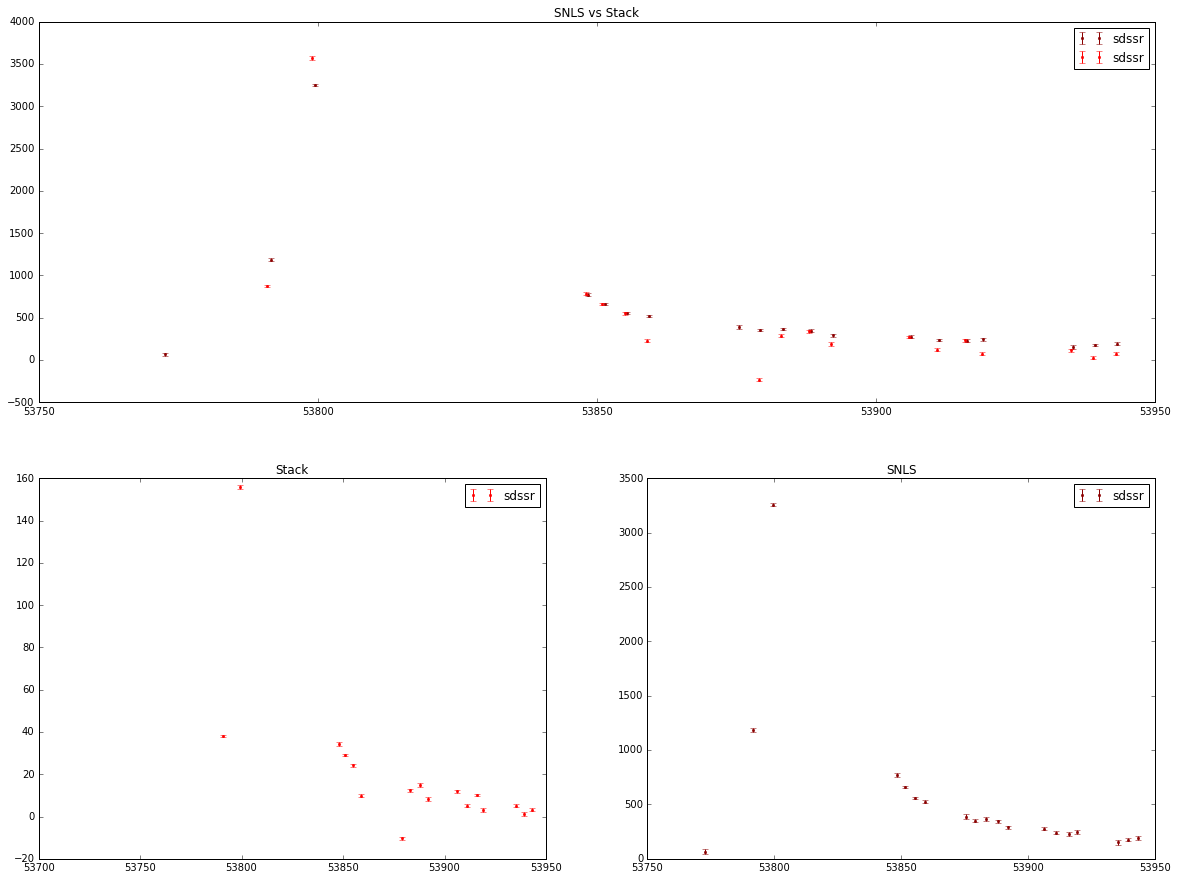

215.571824603 52.9576389543
{'sdssr': 18.897093277134225}


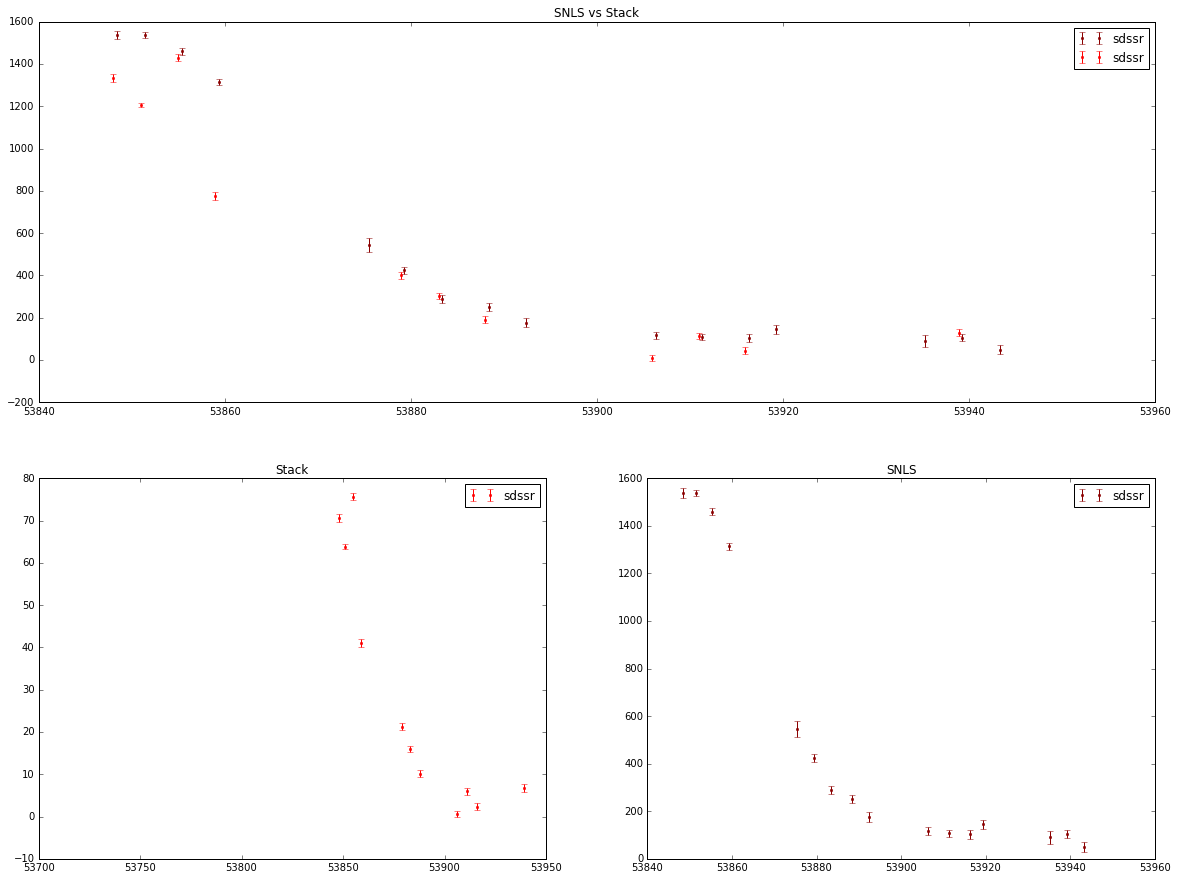

215.55233618 52.6408782585
{'sdssr': 25.961575461916524}


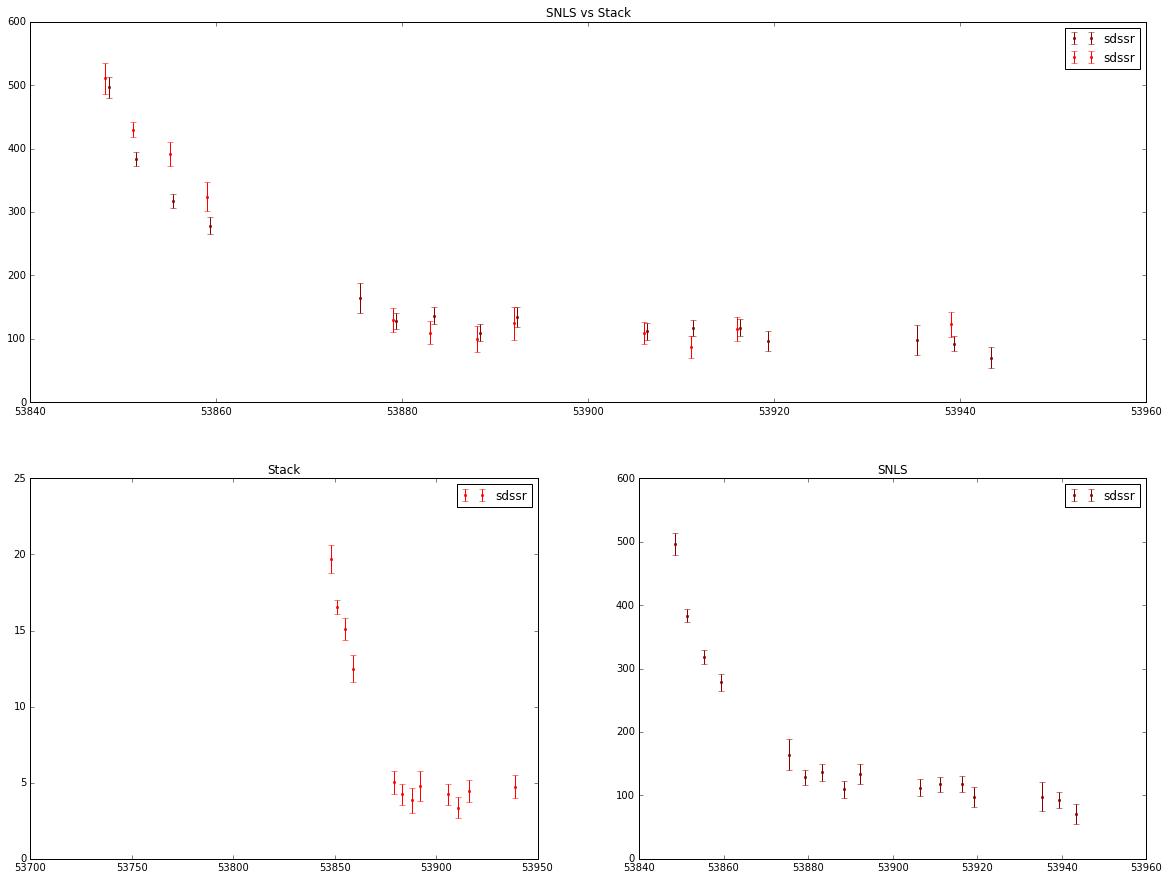

214.247530999 52.8825032645
{'sdssr': 21.281957564689321}


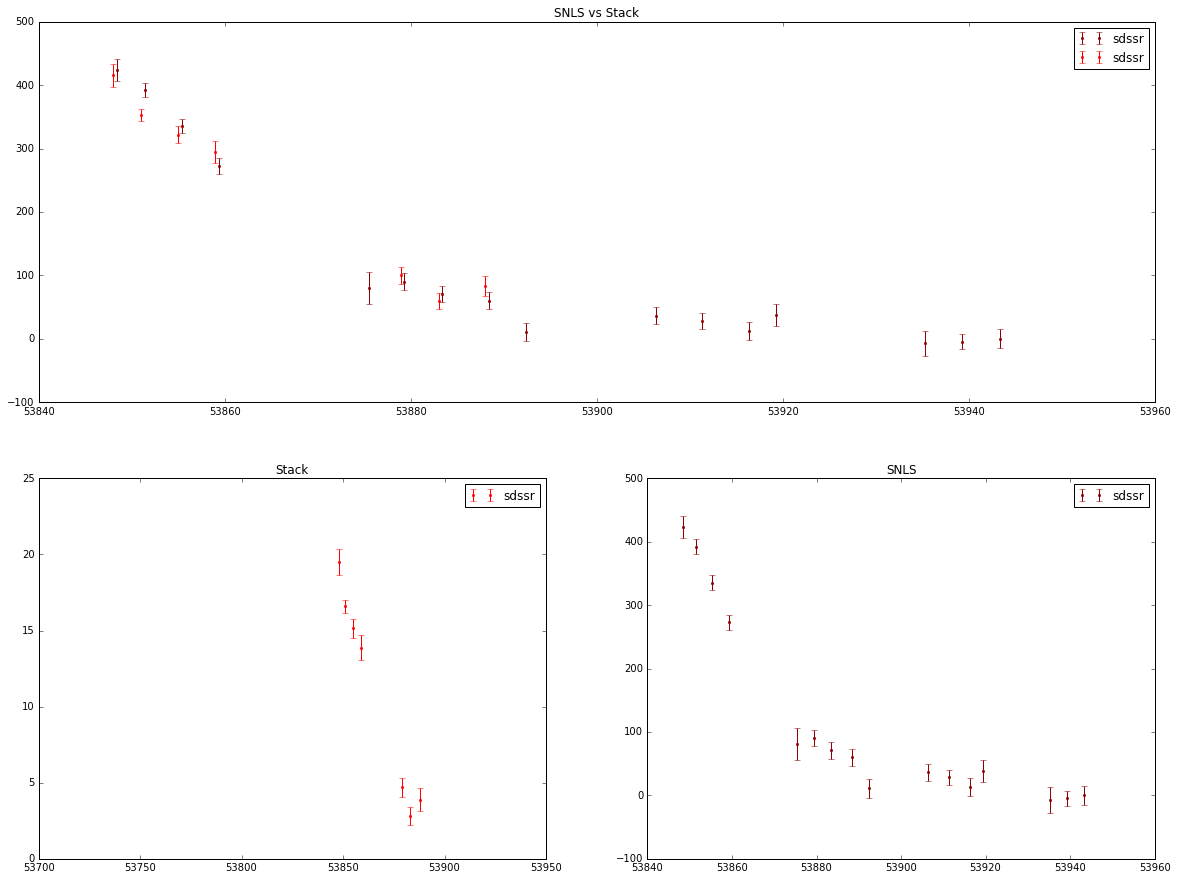

214.247530735 52.8824994777
{'sdssr': 23.370490212387022}


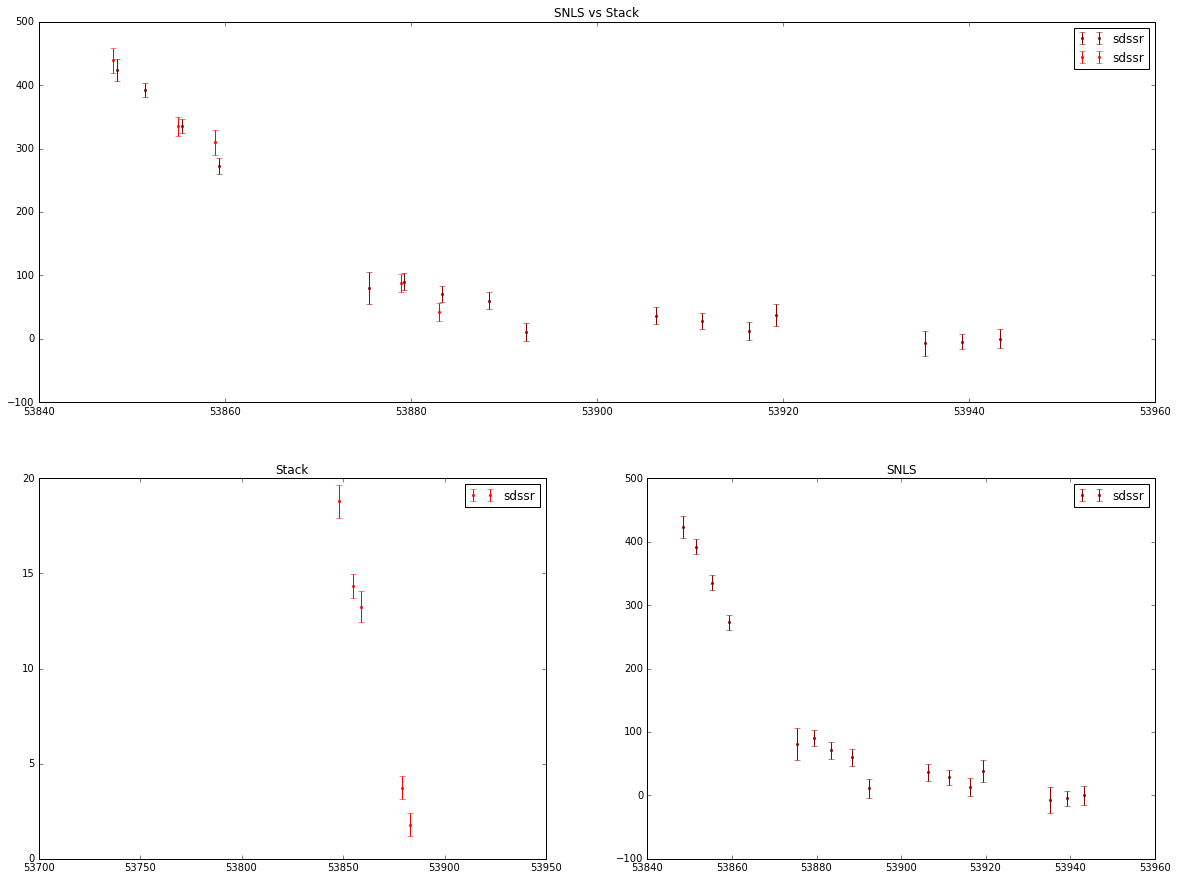

214.340400742 52.452655992
{'sdssr': 161.31143157065333}


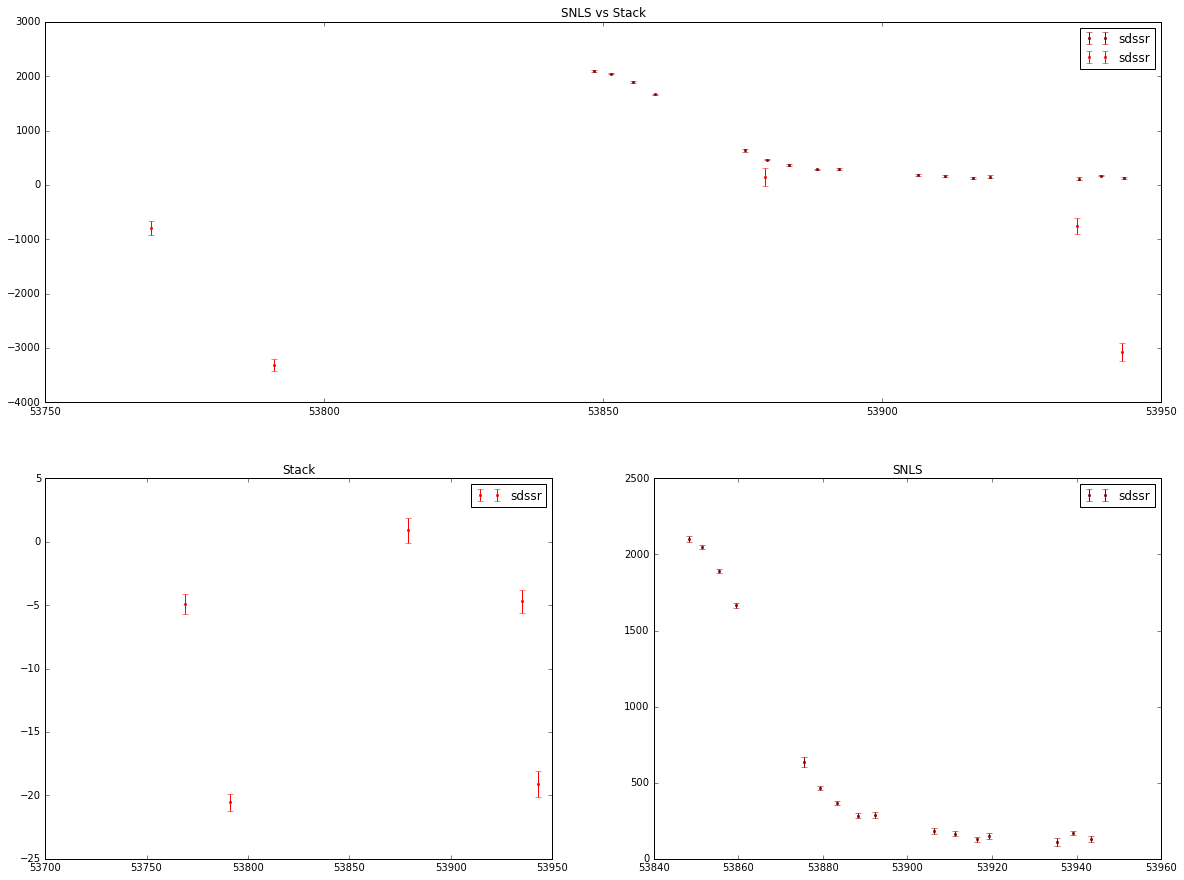

214.340215533 52.4528777555
{'sdssr': 22.943369750197956}


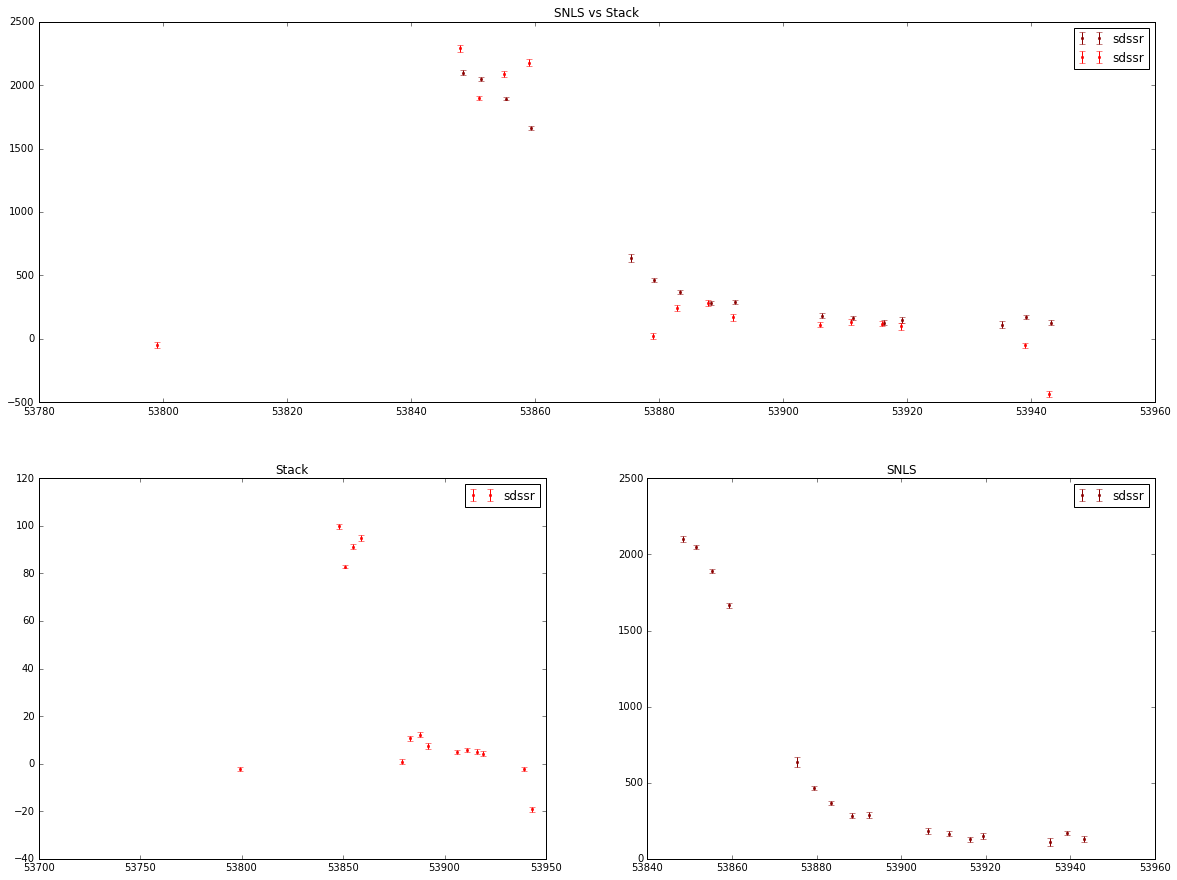

214.699259247 52.7565097145
{'sdssr': 21.734471811945753}


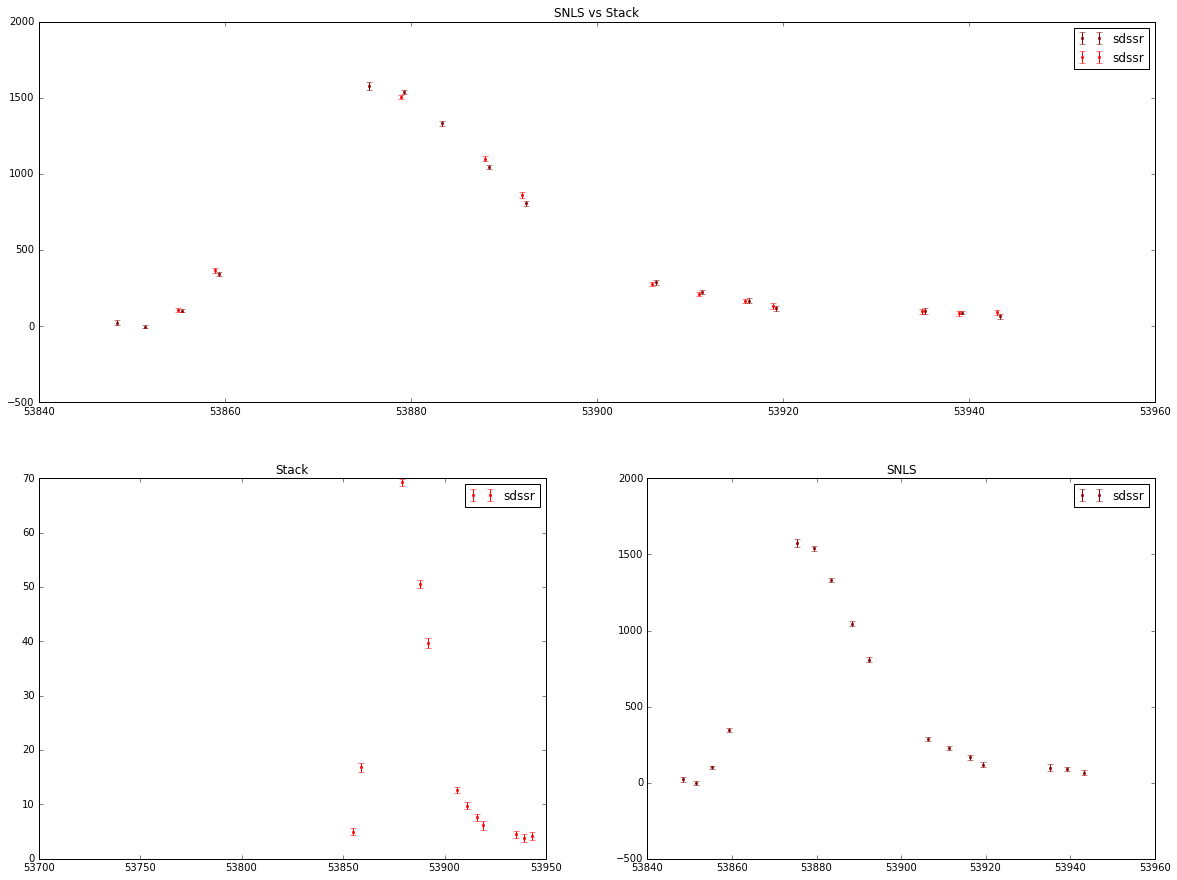

214.699262211 52.7564989457
{'sdssr': 22.3740132897309}


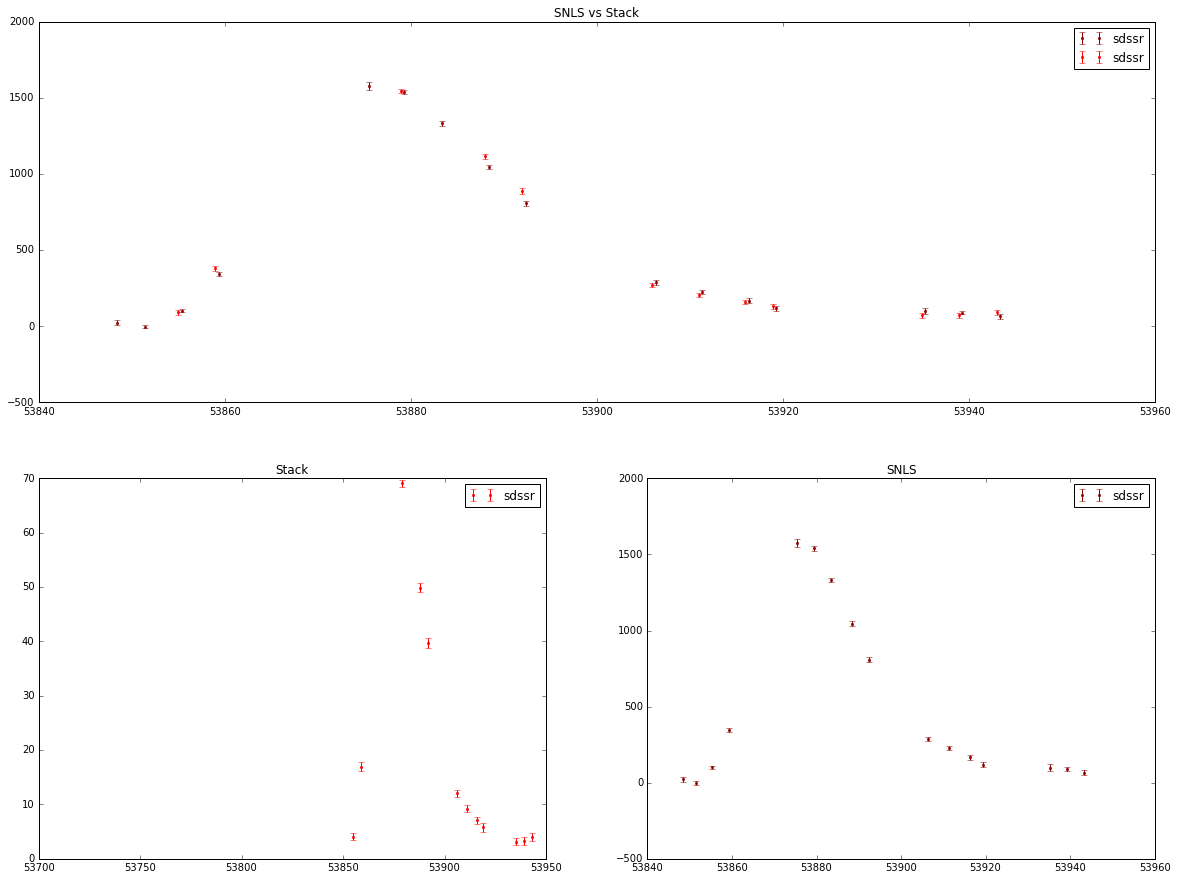

214.254467949 52.2325105018
{'sdssr': 19.662145737797413}


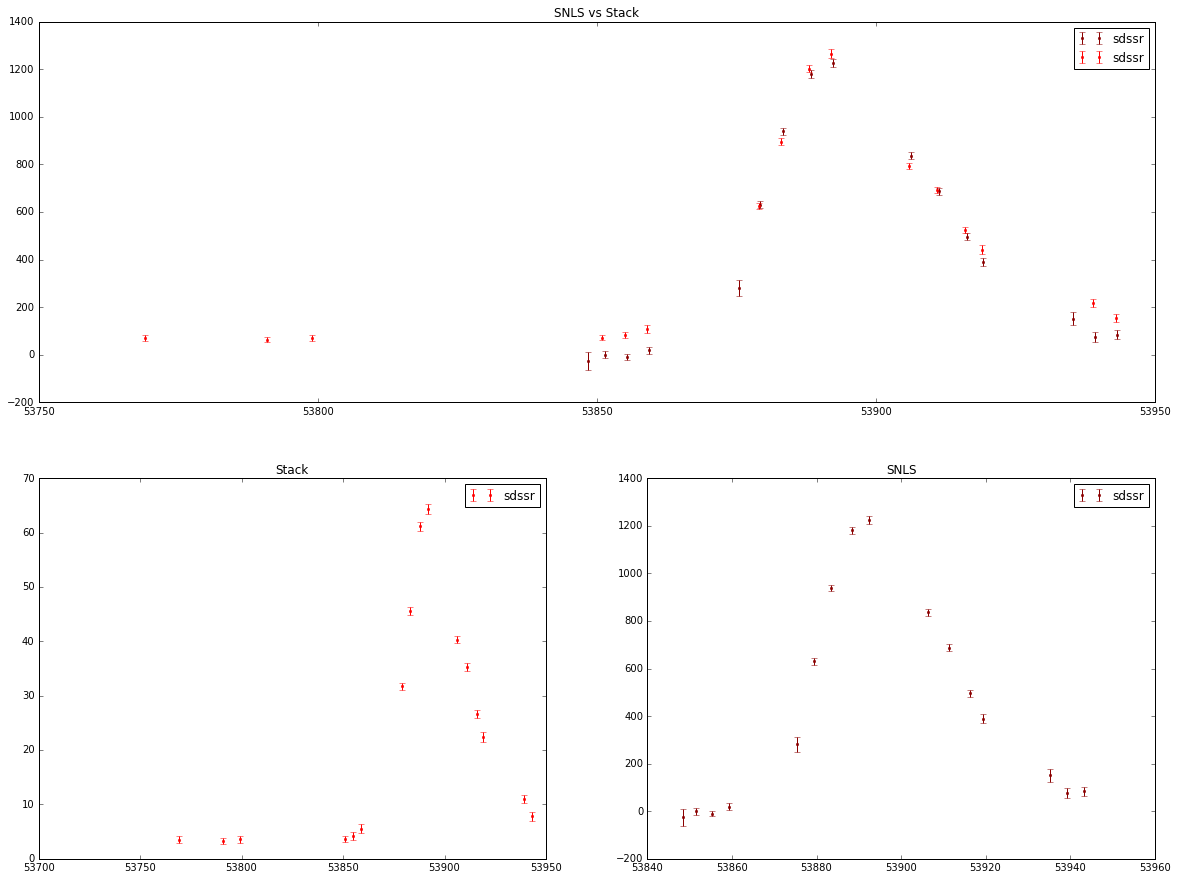

214.847683784 53.0229370839
{'sdssr': 21.334233588217504}


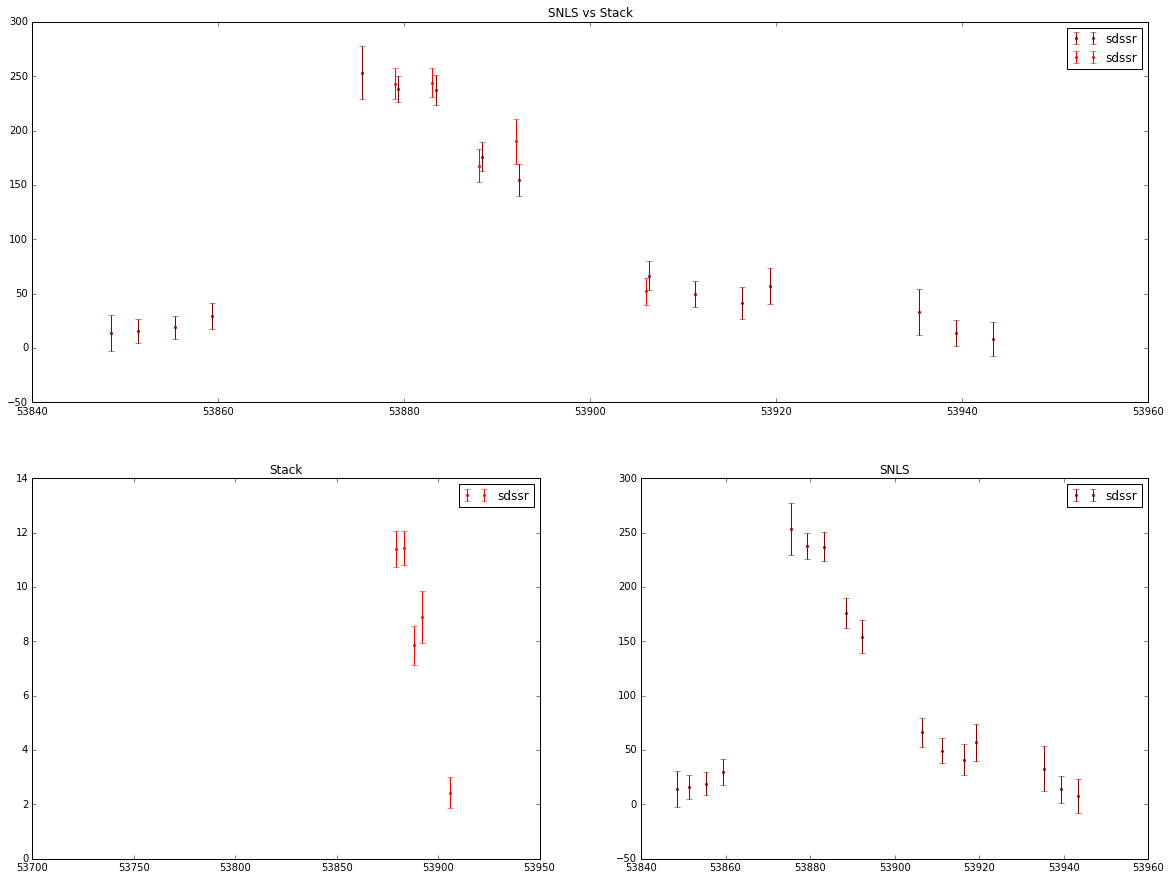

215.519661213 52.3384521498
{'sdssr': 22.901849236869335}


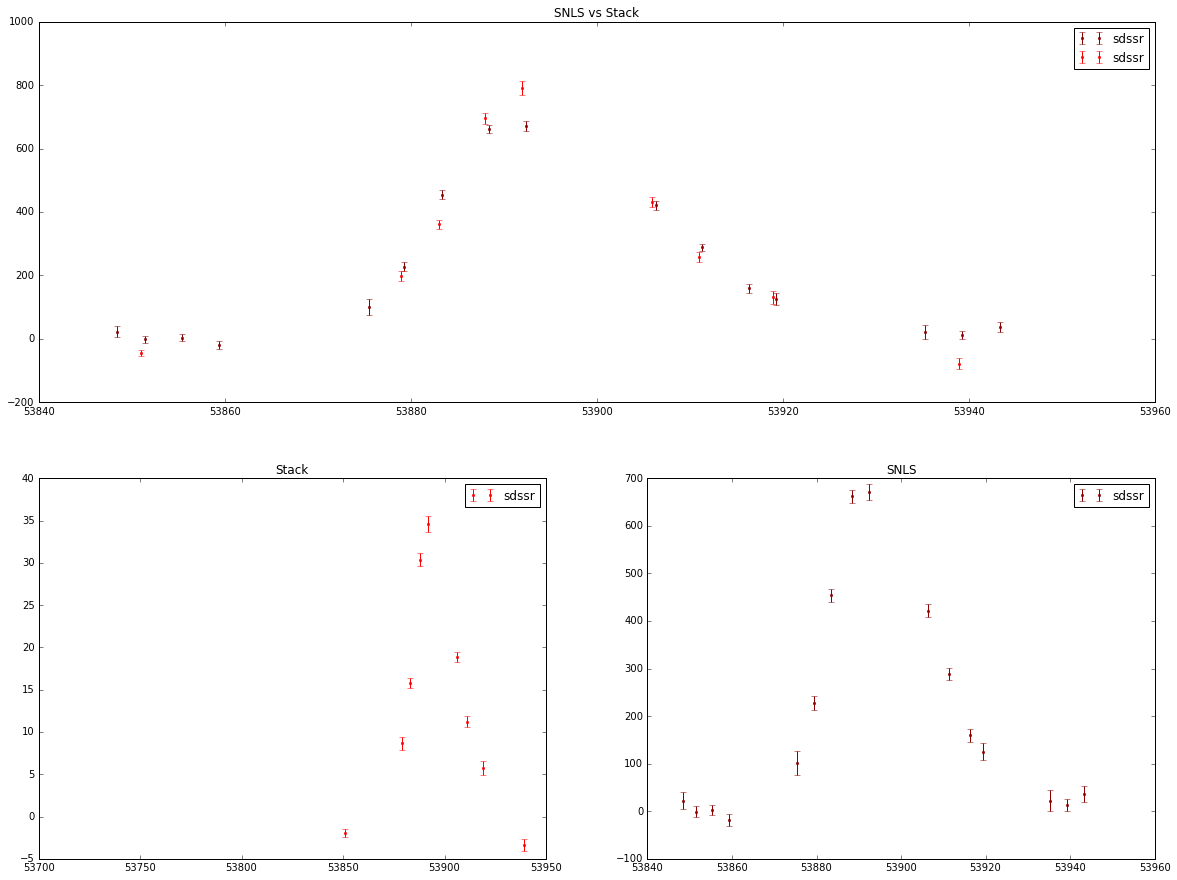

215.077367159 52.8972119337
{'sdssr': 26.976293966301636}


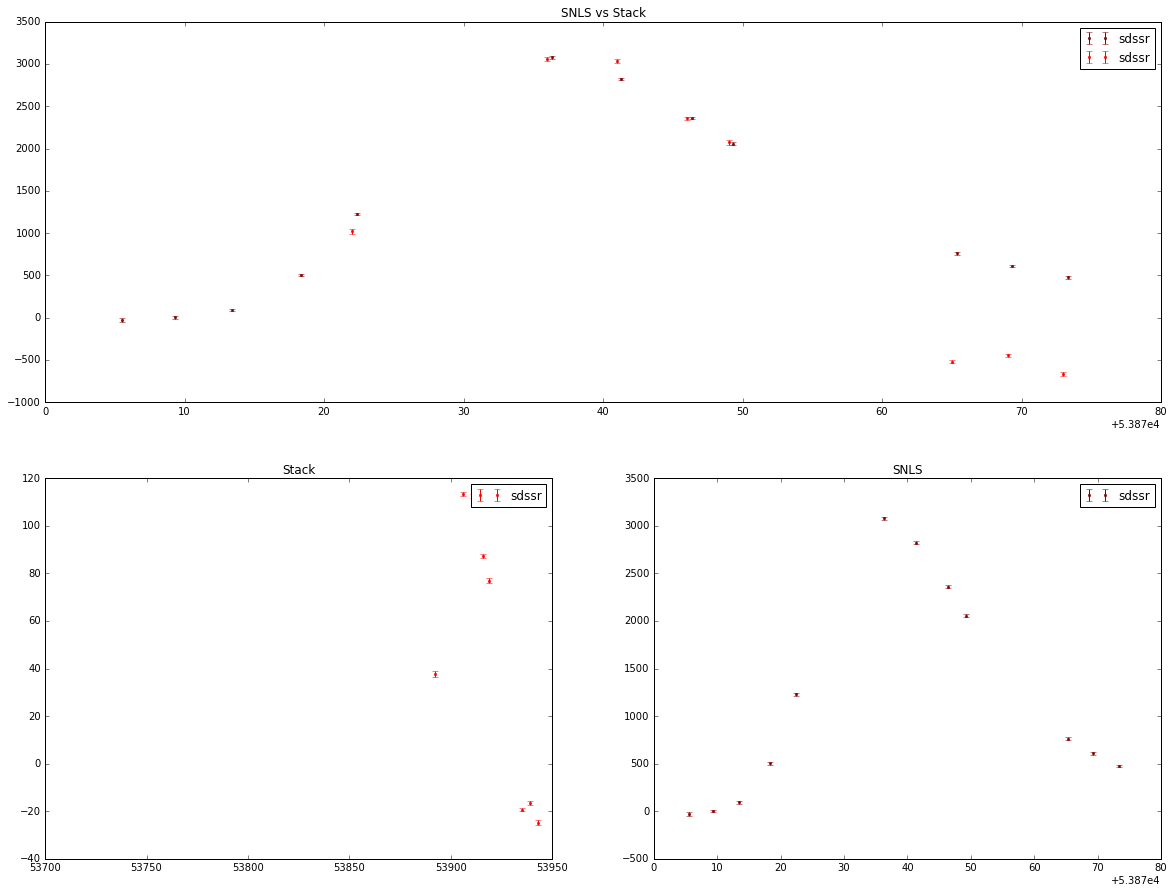

214.630795676 52.4429760833
{'sdssr': 21.283143259812871}


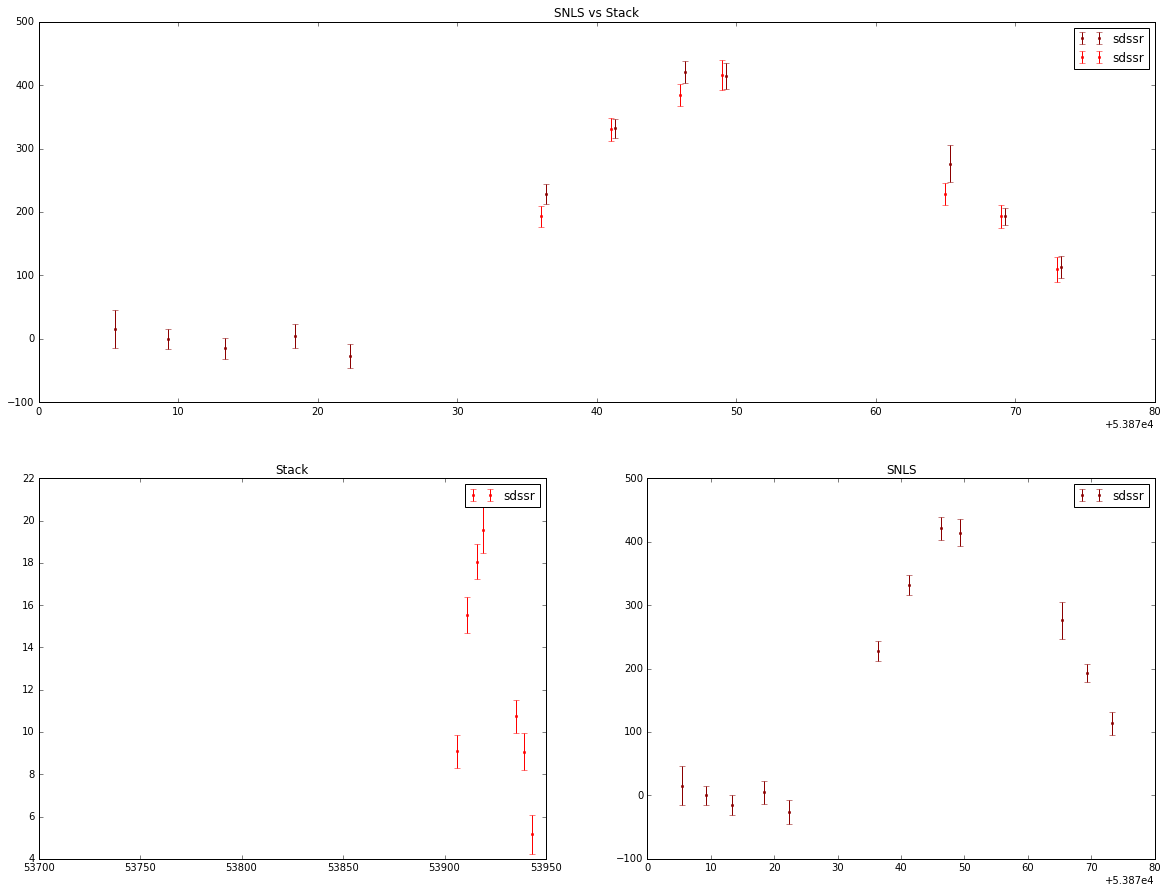

214.263561407 52.936220052
{'sdssr': 18.714677217638233}


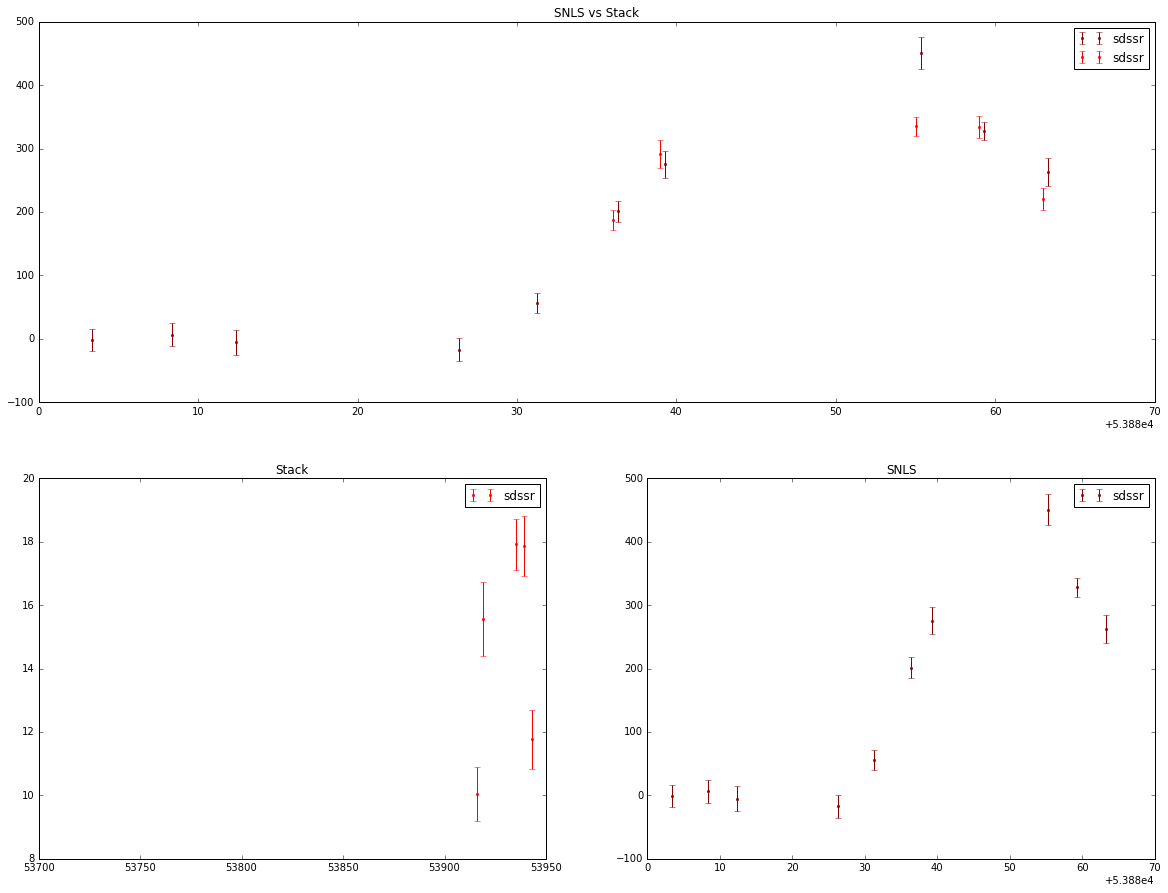

214.263563032 52.9362301572
{'sdssr': 21.214404743056924}


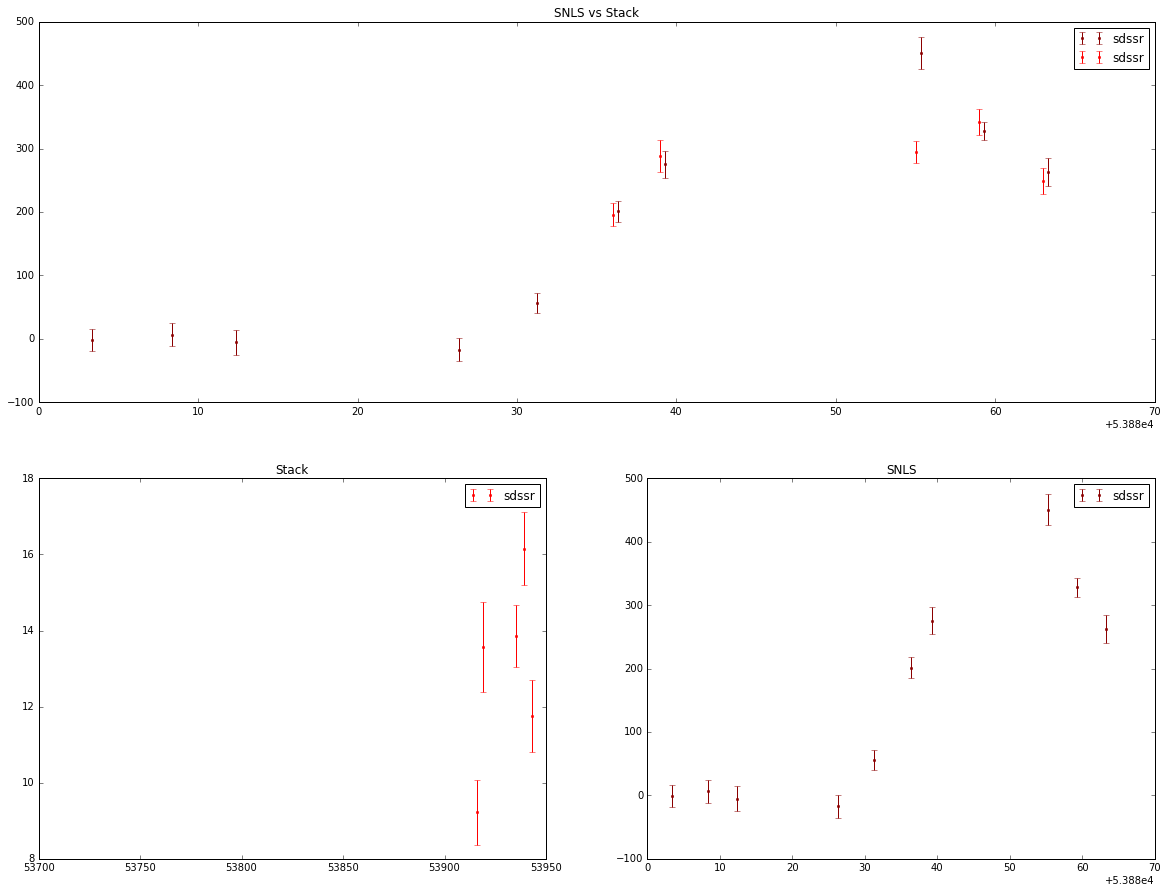

214.263545427 52.9362292051
{'sdssr': 20.620433058516788}


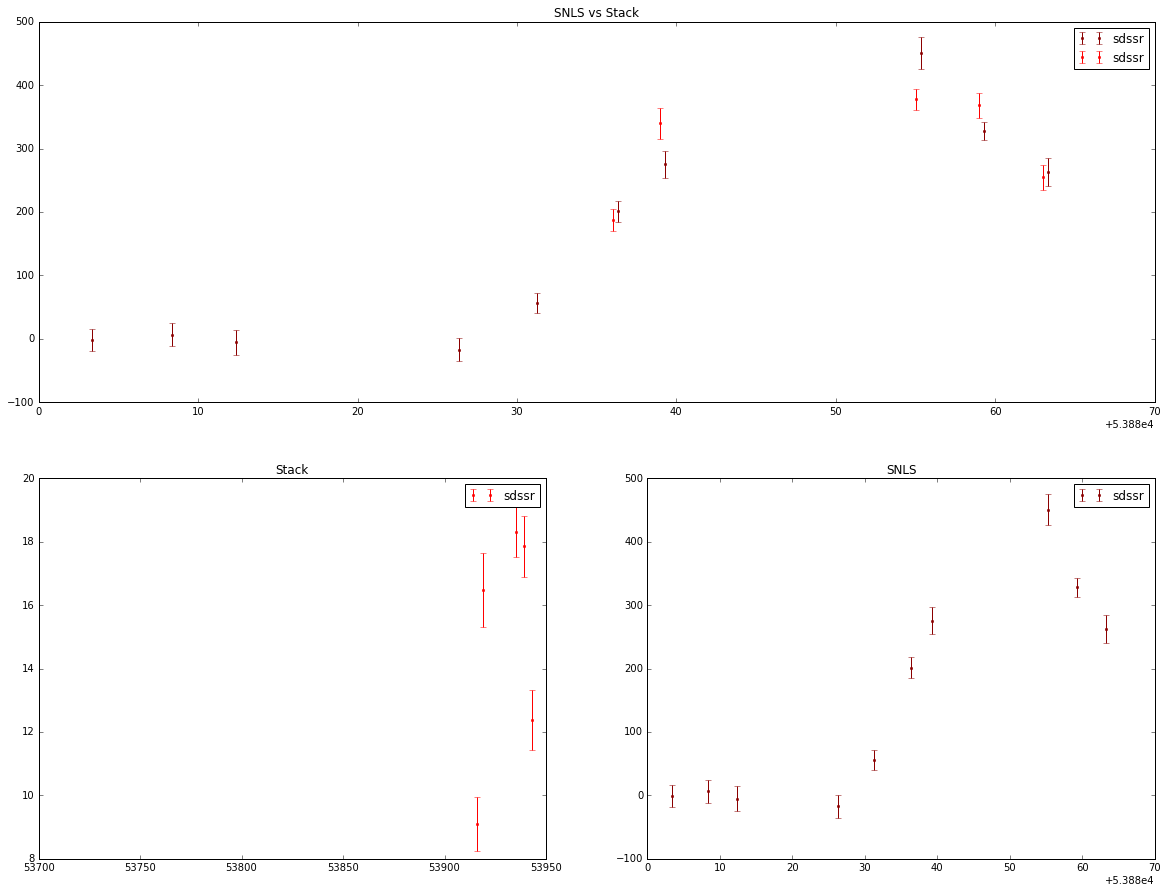

214.263562267 52.9362301132
{'sdssr': 24.836161086392924}


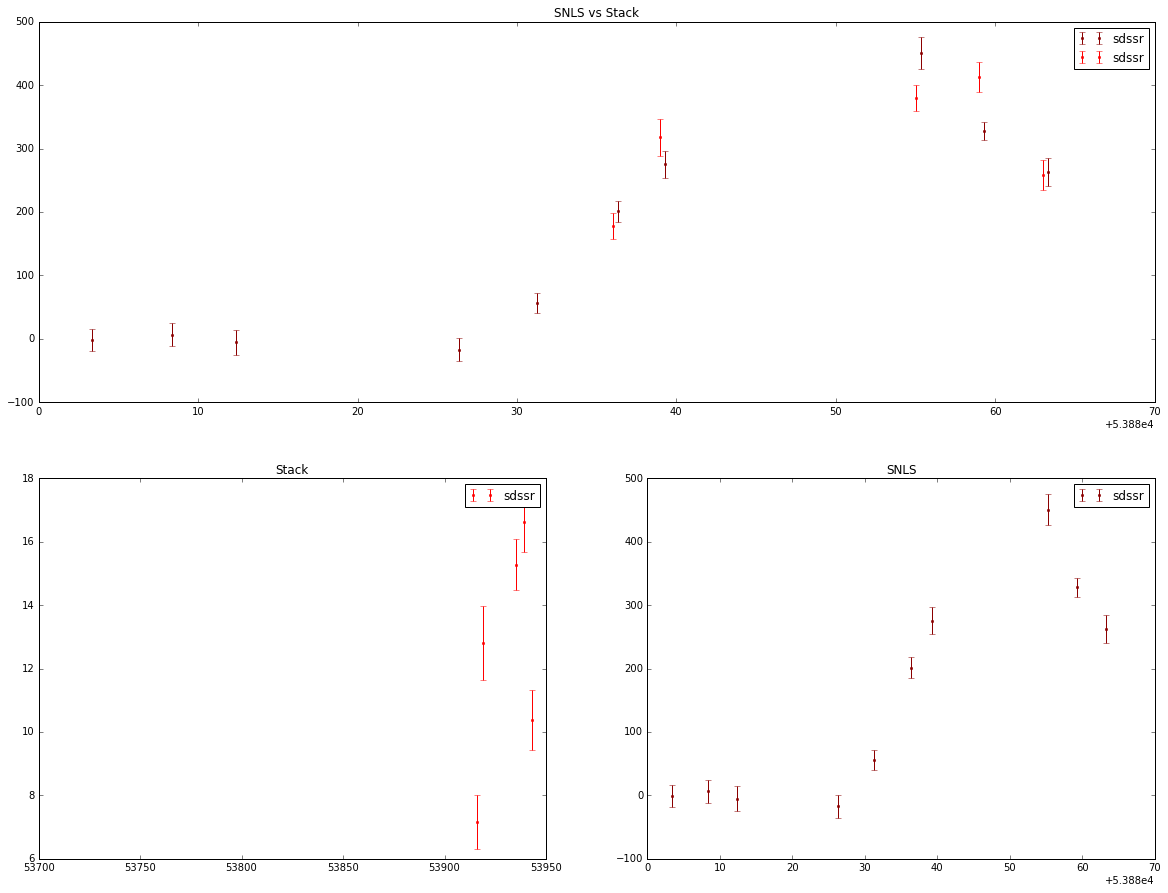

In [17]:
import astropy.coordinates as coord
coords = []
for match in matches_45:
    t = match[-1]
    

    plt.figure(figsize=(20,15))
    c = coord.SkyCoord(ra=float(np.mean(t['ra'])), dec=float(np.mean(t['dec'])), unit=(u.rad))
    print c.ra.deg, c.dec.deg
    coords.append(c)
    plt.subplot2grid((2, 2), (0, 0), colspan=2)
    
    n_factors = {}
#    n_factors["sdssi"]=normalize_light_curve( match[0],t, "sdssi")
#    n_factors["sdssg"]=normalize_light_curve( match[0],t, "sdssg")
    n_factors["sdssr"]=normalize_light_curve( match[0],t, "sdssr")
#    n_factors["sdssz"]=normalize_light_curve( match[0],t, "sdssz")
    
    print n_factors
    
    plt.title("SNLS vs Stack")
    show_multi_filter_light_curve(match[0], snls_colors)
    show_multi_filter_light_curve(t, stack_colors, n_factors)
    
    plt.subplot2grid((2, 2), (1, 0))
    plt.title("Stack")
    plt.xlim(xmin=53700, xmax=53950)
    show_multi_filter_light_curve(t, stack_colors)
    
    plt.subplot2grid((2, 2), (1, 1))
    plt.title("SNLS")
    show_multi_filter_light_curve(match[0], snls_colors)

    plt.show()
    

In [37]:
import astropy.coordinates as coord
import astropy.units as u

c1 = coord.SkyCoord(ra=215.099520256, dec=52.8207065675, unit=(u.deg))
c2 = coord.SkyCoord(ra=215.099758337, dec=52.8208809133, unit=(u.deg))

s1 = {'ra':c1.ra.rad,'dec':c1.dec.rad}
s2 = {'ra':c2.ra.rad,'dec':c1.dec.rad}

print DSTools.source_distance(s1,s2) 


0.857092323955


In [39]:
DATADIR="/datadec/cppm/jpreyes/CFHT_Complete"
directory = DATADIR+"/detect_testSN_2/"
butler = dafPersist.Butler(directory) 

patches = []
patches_file=open(DATADIR+"/patches.txt", "rb")
for line in patches_file:
    line = line.replace('\n','')
    text = re.split("=| ",line)
    patches.append(text[-1])
patches_file.close()

dates = []
days_file=open(DATADIR+"/days_04.txt", "rb")

for day in days_file:
    day = day.replace('\n','')
    dates.append(day)

days_file.close()
print dates

['2004-03-17', '2004-03-19', '2004-03-30', '2004-04-14', '2004-04-17', '2004-04-21', '2004-04-22', '2004-04-26', '2004-04-28', '2004-05-09', '2004-05-13', '2004-05-21', '2004-05-24', '2004-05-26', '2004-06-09', '2004-06-13', '2004-06-19', '2004-06-21', '2004-06-22', '2004-06-26', '2004-07-07', '2004-07-09', '2004-07-11', '2004-07-12', '2004-07-14']


In [47]:
date = dates[0]
patch_and_coord = []
degrees = []
for l, lc  in matches_45:
    for patch in patches:

        if butler.datasetExists("dayDiff_differenceExp", dataId={"filter":'r',"tract":0, "patch":patch, 'date':date}):
                dayDiff = butler.get("dayDiff_differenceExp", dataId={"filter":'r',"tract":0, "patch":patch, 'date':date})
                bbox = dayDiff.getBBox()
                wcs = dayDiff.getWcs()
                
                angle_ra = afwGeom.Angle(lc[0]["ra"])
                angle_dec = afwGeom.Angle(lc[0]["dec"])
                coord = wcs.skyToPixel(angle_ra, angle_dec)
                
                if bbox.contains(afwGeom.Point2I(coord)):
                    patch_and_coord.append((patch, angle_ra.asDegrees(), angle_dec.asDegrees(), np.median(lc['mjd'])))
                    #break
                    
    degrees.append(coord)

In [69]:
patch_and_coord

[('19,10', 214.4377149261246, 52.46781455679339, 53149.0),
 ('19,20', 214.45830178828786, 52.963570208763976, 53117.0),
 ('11,17', 215.0997442198318, 52.820878540836254, 53121.0),
 ('11,17', 215.09965037130732, 52.820783131362134, 53119.0),
 ('18,14', 214.55181886474597, 52.65839335129509, 53121.0),
 ('19,10', 214.45160990855345, 52.470675508458314, 53121.0),
 ('18,6', 214.54155468579816, 52.277690507542914, 53136.0),
 ('18,7', 214.54155468579816, 52.277690507542914, 53136.0),
 ('19,6', 214.44192831171546, 52.2675740753201, 53123.0),
 ('15,22', 214.78250180481274, 53.072048710246825, 53146.0),
 ('17,11', 214.60887743925102, 52.52841512943165, 53151.0),
 ('17,12', 214.60887743925102, 52.52841512943165, 53151.0),
 ('21,8', 214.2411030974021, 52.379498751462684, 53122.0),
 ('21,9', 214.2411030974021, 52.379498751462684, 53122.0),
 ('22,8', 214.2411030974021, 52.379498751462684, 53122.0),
 ('22,9', 214.2411030974021, 52.379498751462684, 53122.0),
 ('5,14', 215.63568815668043, 52.6469613608

In [67]:
def visualize(patch, date, ra, dec, exp, frame=1):
    
    dataId= {"filter":filter,"tract":0, "patch":patch, 'date':date}
    dayDiff = butler.get(exp, dataId=dataId)
    catalog = butler.get("dayDiff_class_diaSrc", dataId=dataId)
    ds9.mtv(dayDiff, frame=frame)
    ds9.setMaskTransparency(100, frame=frame)
    for source in catalog:

        ds9.dot("o", source.getX(), source.getY(), size = 25, ctype = ds9.RED, frame=frame)

    bbox = dayDiff.getBBox()
    wcs = dayDiff.getWcs()

    angle_ra = afwGeom.Angle(ra, afwGeom.degrees)
    angle_dec = afwGeom.Angle( dec , afwGeom.degrees)
    coord = wcs.skyToPixel(angle_ra, angle_dec)
    print coord
    ds9.dot("o", coord.getX(), coord.getY(), size = 20, ctype = ds9.BLUE, frame=frame)

In [82]:
pa = '11,17'
ra = 215.0997442198318
dec = 52.820878540836254
filter='i'
#exp = "dayCoadd"
exp = "dayDiff_differenceExp"

visualize(pa, '2004-04-22', ra , dec , exp, frame = 1)
#visualize('19,21', '2004-03-30', ra, dec,exp, frame = 2)
#visualize('20,20', '2004-03-30', ra, dec,exp, frame = 3)
#visualize('20,21', '2004-03-30', ra, dec,exp, frame = 4)

(11888, 17608)


In [14]:
cls = []
for lc in lcs:
    cls.extend(lc['classification'].tolist())
    
    

In [17]:
SN = []
for match in matches_45:
    SN.append(match[1])

In [19]:
SN[0]

mjd,classification,zpsys,flux,ra,flux_error,dec,zp,bandpass,magnitude,magnitude_error
float64,float64,str2,float64,float64,float64,float64,float64,str5,float64,float64
53766.0,6.0,ab,20.7580127716,3.74009955431,0.688598334789,0.925456622463,25.0,sdssi,26.7070355629,0.0360167493316
53769.0,7.0,ab,22.7090148926,3.74009960239,1.01831281185,0.925456494788,25.0,sdssi,26.6095042622,0.0486863517782
53772.0,7.0,ab,26.3051605225,3.74009958103,0.835618376732,0.925456578781,25.0,sdssi,26.4498976091,0.034489853206
53798.0,7.0,ab,11.4185190201,3.7400995743,0.774245500565,0.925456657581,25.0,sdssi,27.3559755509,0.073619562209
53801.0,7.0,ab,8.68301391602,3.74009950709,0.770874619484,0.925456676568,25.0,sdssi,27.6533237574,0.096391240622
53855.0,7.0,ab,-1.26201415062,3.74009971113,0.86365455389,0.925456661659,25.0,sdssi,nan,nan
53892.0,7.0,ab,-1.43620562553,3.74009986477,0.93831038475,0.925456723615,25.0,sdssi,nan,nan
53910.0,7.0,ab,-1.49595665932,3.74009952573,1.1077747345,0.925456827295,25.0,sdssi,nan,nan
53766.0,7.0,ab,4.36973810196,3.74009970277,0.414177775383,0.92545738509,25.0,sdssg,28.3988614787,0.102909555549


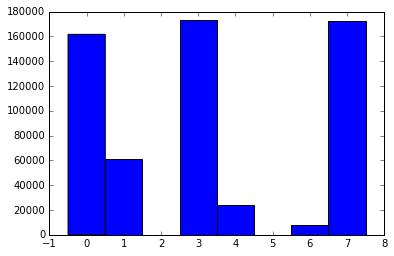

In [15]:
plt.hist(cls, bins=8,  align='left', range=(0,8))
plt.show()

In [111]:
len(lcs)

56620

In [22]:
std_ra

[214.16917115290508,
 214.217589429385,
 214.19936923978443,
 214.23313718524113,
 214.17754337004874,
 214.1961967601035,
 214.22037881456032,
 214.1850842377111,
 214.2280614358449,
 214.22538974588483,
 214.2088854851062,
 214.2044937056413,
 214.22563881761045,
 214.21330149284762,
 214.2260507112822,
 214.21846961102918,
 214.20726284428068,
 214.20994598580353,
 214.21617668287917,
 214.18710360540243,
 214.1930396462694,
 214.21129982325627,
 214.17510514448102,
 214.18425174013834,
 214.20399036619833,
 214.18021008757097,
 214.17572178409628,
 214.19586372733863,
 214.15679335832812,
 214.21631094101488,
 214.2110982323934,
 214.18481263973322,
 214.18723880399463,
 214.2050200084048,
 214.21590363323156,
 214.2308798643069,
 214.15791148571435,
 214.20084997775083,
 214.21267755290032,
 214.19079248002836,
 214.21658007101883,
 214.2091630102927,
 214.1746920583789,
 214.23785609678197,
 214.18663648144945,
 214.17126303607327,
 214.16076460822484,
 214.22074274655316,
 214.2

In [20]:
std_ra = []
std_dec = []

for i, lc in enumerate(SN):
    #print i
    c = coord.SkyCoord(np.std(lc["ra"]),np.std(lc["dec"]), unit=( u.rad))
    std_ra.append(c.ra.deg)
    std_dec.append(c.dec.deg)

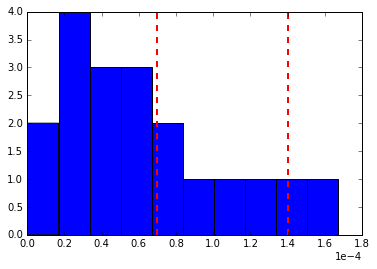

In [24]:
plt.hist(std_ra,  align='left')
plt.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
plt.axvline(0.00014, color='r', linestyle='dashed', linewidth=2)
plt.axvline(0.00007, color='r', linestyle='dashed', linewidth=2)

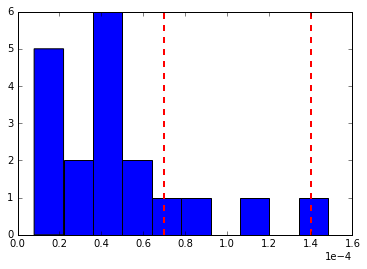

In [25]:
plt.hist(std_dec,  align='left')
plt.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
plt.axvline(0.00014, color='r', linestyle='dashed', linewidth=2)
plt.axvline(0.00007, color='r', linestyle='dashed', linewidth=2)